### Project Setup

In [1]:
import mlx.core as mx
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm, trange
from pathlib import Path
from matplotlib.colors import ListedColormap, BoundaryNorm
import ipywidgets as widgets

### File Location

In [2]:
ROOT = Path.cwd()
MAT_DIR = ROOT / "MAT Files"
GT_DIR = ROOT / "GT Files"

### Datasets - Files & Keys

In [3]:
DATASETS = {
    "Pavia": {
        "data_file": "Pavia.mat",
        "gt_file":   "Pavia_gt.mat",
        "data_key":  "pavia",
        "gt_key":    "pavia_gt",
    },
    "PaviaUni": {
        "data_file": "PaviaUni.mat",
        "gt_file":   "PaviaU_gt.mat",
        "data_key":  "paviaU",
        "gt_key":    "paviaU_gt",
    },
}

In [4]:
DEFAULT_DS = "Pavia"

ds = widgets.Dropdown(options=list(DATASETS.keys()),
                      value=DEFAULT_DS,
                      description="Dataset:")
out = widgets.Output()

display(ds, out)

Dropdown(description='Dataset:', options=('Pavia', 'PaviaUni'), value='Pavia')

Output()

In [5]:
keys = DATASETS[ds.value]

In [6]:
keys

{'data_file': 'Pavia.mat',
 'gt_file': 'Pavia_gt.mat',
 'data_key': 'pavia',
 'gt_key': 'pavia_gt'}



## Hyperspectral Image Cube

In [7]:
def load_ds(name: str):
    """Load data for the selected dataset and put into globals()."""
    cfg = DATASETS[name]
    data_mat = sio.loadmat(os.path.join(MAT_DIR, cfg["data_file"]))
    gt_mat   = sio.loadmat(os.path.join(GT_DIR,  cfg["gt_file"]))
    globals()["data_cube"] = data_mat[cfg["data_key"]]
    globals()["gt_data"]   = gt_mat[cfg["gt_key"]]
    with out:
        out.clear_output(wait=True)
        print(f"Loaded {name}: X {data_cube.shape}, GT {gt_data.shape}")


In [8]:
def _on_change(change):
    if change["name"] == "value":
        load_ds(change["new"])

In [9]:
ds.observe(_on_change, names="value")

In [10]:
load_ds(ds.value)

## Ground Truth Data

In [11]:
gt_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1096, 715), dtype=uint8)

In [12]:
gt_data.shape

(1096, 715)

In [13]:
gt_labels = np.sort(np.unique(gt_data))

In [14]:
num_labels = len(gt_labels)

In [15]:
bg_indices = gt_data == 0

In [16]:
filter = mx.ones([data_cube.shape[0], data_cube.shape[1]])

In [17]:
mask = mx.where(bg_indices, 0.0, filter)

In [18]:
mask[1, 1]

array(0, dtype=float32)

In [19]:
mask3d = mask[..., None]

In [20]:
masked_cube = mx.multiply(data_cube, mask3d)

In [21]:
masked_cube.shape

(1096, 715, 102)

In [22]:
type(data_cube)

numpy.ndarray

In [23]:
type(masked_cube)

mlx.core.array

In [24]:
masked_cube_reshaped = mx.reshape(masked_cube, (masked_cube.shape[0]*masked_cube.shape[1], masked_cube.shape[2]))

In [25]:
masked_cube_reshaped.shape

(783640, 102)

In [26]:
masked_cube_reshaped

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=float32)

In [27]:
cube_np = np.array(masked_cube_reshaped)
nonzero_mask = np.any(cube_np != 0, axis=1)
filtered_np = cube_np[nonzero_mask]
filtered_pixels = mx.array(filtered_np)

In [28]:
## Plotting

In [29]:
def polar(x):
    M, N = x.shape
    k = mx.minimum(M, N).item()
    U, S, Vt = mx.linalg.svd(x, stream=mx.cpu)
    return U[:, :k] @ Vt

In [30]:
def KSS(X, d, *, niters=100, Uinit=None):
    K = len(d)
    D, N  = X.shape

    ## Initialize
    
    if Uinit is None:
        U = [polar(mx.random.normal(shape=(D, di))) for di in d]
    else:
        U = [Uk for Uk in Uinit]

    scores = mx.stack(
        [mx.sum(mx.matmul(Uk.T, X, stream = mx.gpu)**2, axis=0) for Uk in U],
        axis=0
    )
    c = np.argmax(np.array(scores), axis=0)
    c_prev = c.copy()
    
    # Iterations
    for t in trange(niters, desc="KSS", leave=False):
        # Update Subspaces
        for k in range(K):
            ilist = np.nonzero(c == k)[0]
            mlx_ilist = mx.array(ilist)
            if ilist.size == 0:
                mx.random.seed(k + 42)
                U[k] = polar(mx.random.normal(shape=(X.shape[0], d[k])))
            else:
                X_k = mx.take(X, mlx_ilist, axis=1)
                A = mx.matmul(X_k, X_k.T, stream = mx.gpu)
                w, V = mx.linalg.eigh(A, stream = mx.cpu)
                U[k] = V[:, -d[k]:]

        # Update clusters
        scores = mx.stack(
            [mx.sum(mx.matmul(Uk.T, X, stream = mx.gpu)**2, axis=0) for Uk in U],
            axis=0
        )
        c = np.argmax(np.array(scores), axis=0).astype(np.int32) + 1

        # Break if clusters did not change, update otherwise
        if np.array_equal(c, c_prev):
            print(f"Terminated early at iteration {t+1}")
            break
        else:
            c_prev = c.copy() 
    
    return U, mx.array(c)

In [31]:
def batch_KSS(X, d, *, niters=100, nruns=10):
    D, N = X.shape
    runs = [None] * nruns
    for idx in trange(nruns, desc="batch KSS", leave=False):
        mx.random.seed(idx+1)
        U, c_mx = KSS(X, d, niters=niters)

        total_cost = 0.0
        for i in range(N):
            cluster_idx = int(c_mx[i].item())
            cost = mx.sum(mx.matmul(U[cluster_idx - 1].T, X[:, i], stream=mx.gpu)**2, axis=0)
            total_cost += float(cost.item())

        runs[idx] = (U, c_mx, total_cost)

    return runs

In [32]:
KSS_Runs = batch_KSS(filtered_pixels.T, [2, 2, 3, 2, 3, 2, 2, 2, 3], nruns=10)

batch KSS:   0%|          | 0/10 [00:00<?, ?it/s]

KSS:   0%|          | 0/100 [00:00<?, ?it/s]

KSS:   0%|          | 0/100 [00:00<?, ?it/s]

KSS:   0%|          | 0/100 [00:00<?, ?it/s]

KSS:   0%|          | 0/100 [00:00<?, ?it/s]

KSS:   0%|          | 0/100 [00:00<?, ?it/s]

KSS:   0%|          | 0/100 [00:00<?, ?it/s]

KSS:   0%|          | 0/100 [00:00<?, ?it/s]

KSS:   0%|          | 0/100 [00:00<?, ?it/s]

KSS:   0%|          | 0/100 [00:00<?, ?it/s]

KSS:   0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
totalcosts = [KSS_Runs[i][2] for i in range(len(KSS_Runs))]

In [34]:
minidx_KSS = int(np.argmax(totalcosts))

In [35]:
c = KSS_Runs[minidx_KSS][1]

In [36]:
c_np = np.array(c)

In [37]:
for k in range(1, num_labels):
    ilist = np.nonzero(c_np == k)[0]
    print(f"Cluster {k}: {ilist}")

Cluster 1: []
Cluster 2: []
Cluster 3: [     0      2      4 ... 148149 148150 148151]
Cluster 4: [   206   2809   4798   4971   5150   5333   5682   7544   9008  13239
  13240  14466  15411  16440  16789  17819  18164  20271  20613  20950
  21293  22346  22712  24594  25368  26159  31958  32724  33488  35010
  36561  39180  42878  42879  43594  49715  60000  60001  60223  60224
  60225  60445  60447  60678  60679  60924  60925  61187  61188  61189
  61459  61460  61722  61723  61989  61990  61991  62258  62259  62528
  62529  62802  62803  62804  63075  63076  63077  63338  63340  63341
  63605  63606  70991  71218  71219  71220  71221  71453  71454  71455
  71456  71694  71695  71696  71944  71945  72203  72204  72467  72468
  78760  79054  79660  79661  79662  79663  79972  79973  79974  79978
  80287  80288  80289  80290  80291  80294  80596  80598  80604  80900
  80901  81196  81199  81201  81202  81476  81478  81479  81481  81483
  81485  81486  81750  81752  81754  81755  81756 

In [38]:
c_np[324]

np.int32(5)

### Creating a clustermap

In [39]:
label_px = gt_data > 0 # Returns a boolean map with background pixels stored as False

clustermap = np.zeros_like(gt_data, dtype=np.int32) # Create a zero filled 2D array size of gt_data

clustermap[label_px] = c_np # Fills the foreground pixels

In [50]:
filtered_pixels.T

array([[265, 212, 373, ..., 450, 777, 466],
       [499, 313, 276, ..., 460, 429, 284],
       [351, 190, 200, ..., 363, 347, 260],
       ...,
       [173, 175, 157, ..., 4271, 3979, 3531],
       [169, 143, 133, ..., 4260, 3934, 3511],
       [170, 127, 128, ..., 4264, 3939, 3529]], dtype=float32)

### Plot - Ground Truth Vs Cluster assignment

In [40]:
def plot_gt_vs_clusters(gt_data, clustermap, title_left="Ground Truth", title_right="KSS Clustering Results"):
    gt_max = int(np.max(gt_data))
    km_max = int(np.max(clustermap))
    n_classes = max(gt_max, km_max)

    # color 0 = background (black); then categorical colors for 1..n_classes
    base = plt.cm.tab20.colors  # plenty of distinct colors
    palette = ['black'] + [base[i % len(base)] for i in range(n_classes)]
    cmap = ListedColormap(palette)
    norm = BoundaryNorm(np.arange(n_classes + 2) - 0.5, cmap.N)  # hard bins at integers

    fig, axes = plt.subplots(1, 2, figsize=(9, 7), constrained_layout=True)

    im0 = axes[0].imshow(gt_data, cmap=cmap, norm=norm, interpolation='nearest')
    axes[0].set_title(title_left, fontsize=16)
    axes[0].axis('equal'); axes[0].set_xticks([]); axes[0].set_yticks([])

    im1 = axes[1].imshow(clustermap, cmap=cmap, norm=norm, interpolation='nearest')
    axes[1].set_title(title_right, fontsize=16)
    axes[1].axis('equal'); axes[1].set_xticks([]); axes[1].set_yticks([])

    # one colorbar per panel with integer ticks (0..n_classes)
    ticks = np.arange(0, n_classes + 1, 1)
    cbar0 = fig.colorbar(im0, ax=axes[0], ticks=ticks, orientation='horizontal', fraction=0.046, pad=0.05)
    cbar1 = fig.colorbar(im1, ax=axes[1], ticks=ticks, orientation='horizontal', fraction=0.046, pad=0.05)

    plt.show()

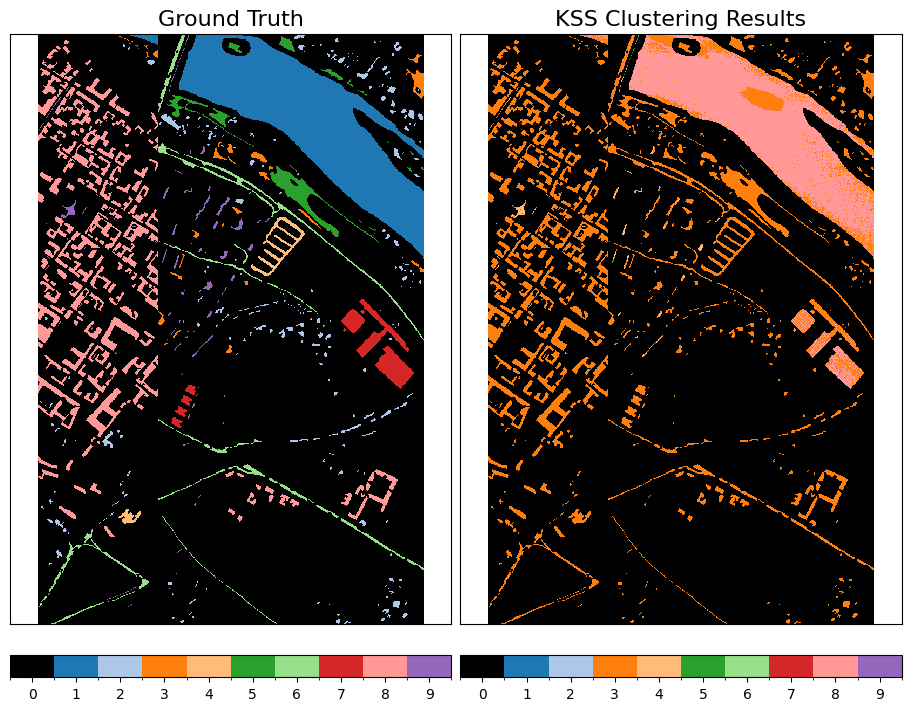

In [41]:
plot_gt_vs_clusters(gt_data, clustermap)

### Rough Work

In [42]:
base = plt.cm.tab20.colors

In [43]:
base

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.74117647

In [44]:
a = mx.array([[1, 2, 3, 4], [2, 3, 4, 5]])

In [45]:
mx.metal.is_available()

True

In [46]:
x = mx.random.normal((1000, 1000))

In [47]:
mx.metal.device_info()

{'resource_limit': 499000,
 'max_buffer_length': 10726686720,
 'architecture': 'applegpu_g15s',
 'memory_size': 19327352832,
 'max_recommended_working_set_size': 14302248960,
 'device_name': 'Apple M3 Pro'}

In [48]:
print(mx.__version__)

0.29.3
